<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/3D_RESNET3_BC_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#3D-ResNet

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)



---
2D Model -> 3D ResNet Model

---


```
No slice selection


Training Performance:
Training accuracy improved from 55% → 88%
Loss decreased from 0.82 → 0.31
Model is learning training patterns effectively

Test Performance:
Validation accuracy plateaued at ~56%
Test accuracy: 50% (random chance level)
Precision/recall/F1 all near 0.5
```

**Problem :**
            

> model is overfitting:  large 3D models can overfit on small datasets.


> Model Generalization is Poor

>Missing Regularization

**learning**
<br>3D images needs more compution (GPUs)

get tha dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import

In [ ]:
# --- Imports and Setup ---
import os
import random
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models.video import r3d_18  # 3D ResNet
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from scipy.ndimage import zoom

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



3D Dataset Class

In [ ]:
class MRI3DDataset(Dataset):
    def __init__(self, samples, target_shape=(128, 128, 128)):
        self.samples = samples  # [(nii_path, label)]
        self.target_shape = target_shape

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = self.resize_volume(img, self.target_shape)
        img = img[np.newaxis, ...].astype(np.float32)  # (C, D, H, W)
        return torch.tensor(img), label

    def resize_volume(self, volume, target_shape):
        depth, height, width = volume.shape
        target_depth, target_height, target_width = target_shape
        depth_factor = target_depth / depth
        height_factor = target_height / height
        width_factor = target_width / width
        return zoom(volume, (depth_factor, height_factor, width_factor), order=1)


Data Preparation

In [ ]:
root_dir = '/content/drive/MyDrive/MRI_DATASET/nifti_with_metadata/nifti_with_metadata'
class_names = ['AD', 'CN']
class_map = {'CN': 0, 'AD': 1}
random.seed(42)

train_samples, val_samples, test_samples = [], [], []

for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    subjects = sorted(os.listdir(class_dir))
    random.shuffle(subjects)
    n_total = len(subjects)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    for subj_list, sample_list in zip([subjects[:n_train],
                                      subjects[n_train:n_train+n_val],
                                      subjects[n_train+n_val:]],
                                     [train_samples, val_samples, test_samples]):
        for subj in subj_list:
            subj_dir = os.path.join(class_dir, subj)
            nii_files = [f for f in os.listdir(subj_dir)
                         if f.endswith(('.nii', '.nii.gz'))]
            if nii_files:
                nii_path = os.path.join(subj_dir, nii_files[0])
                sample_list.append((nii_path, class_map[cls]))


Data Loaders

In [ ]:
batch_size = 4  # 3D volumes require more memory
target_shape = (128, 128, 128)

train_dataset = MRI3DDataset(train_samples, target_shape)
val_dataset = MRI3DDataset(val_samples, target_shape)
test_dataset = MRI3DDataset(test_samples, target_shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


3D Resnet Model

In [ ]:
class ResNet3D(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = r3d_18(pretrained=False)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7),
                                        stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)

model = ResNet3D().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

for epoch in range(15):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for volumes, labels in train_loader:
        volumes, labels = volumes.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(volumes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * volumes.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for volumes, labels in val_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            outputs = model(volumes)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader.dataset):.4f} "
          f"Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")


Epoch 1: Loss=0.8188 Train Acc=55.33% Val Acc=50.00%
Epoch 2: Loss=0.7118 Train Acc=51.33% Val Acc=53.12%
Epoch 3: Loss=0.6786 Train Acc=56.67% Val Acc=62.50%
Epoch 4: Loss=0.6888 Train Acc=56.00% Val Acc=59.38%
Epoch 5: Loss=0.6853 Train Acc=58.00% Val Acc=50.00%
Epoch 6: Loss=0.7030 Train Acc=52.00% Val Acc=56.25%
Epoch 7: Loss=0.6297 Train Acc=68.00% Val Acc=68.75%
Epoch 8: Loss=0.6190 Train Acc=69.33% Val Acc=53.12%
Epoch 9: Loss=0.5532 Train Acc=71.33% Val Acc=50.00%
Epoch 10: Loss=0.5755 Train Acc=74.00% Val Acc=56.25%
Epoch 11: Loss=0.5247 Train Acc=74.67% Val Acc=56.25%
Epoch 12: Loss=0.3932 Train Acc=82.67% Val Acc=59.38%
Epoch 13: Loss=0.3543 Train Acc=82.67% Val Acc=56.25%
Epoch 14: Loss=0.3668 Train Acc=86.00% Val Acc=59.38%
Epoch 15: Loss=0.3069 Train Acc=88.00% Val Acc=56.25%


Validation and  Metrics

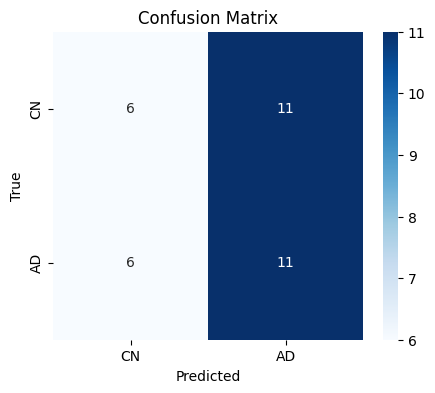

              precision    recall  f1-score   support

          CN       0.50      0.35      0.41        17
          AD       0.50      0.65      0.56        17

    accuracy                           0.50        34
   macro avg       0.50      0.50      0.49        34
weighted avg       0.50      0.50      0.49        34



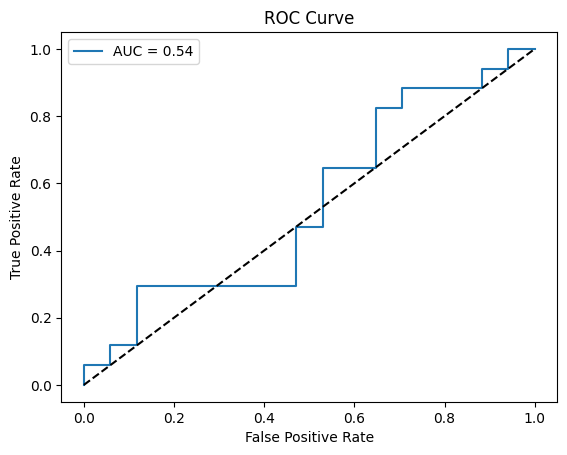

ROC AUC: 0.536


In [ ]:
model.eval()
all_preds, all_targets, all_probs = [], [], []

with torch.no_grad():
    for volumes, labels in test_loader:
        volumes = volumes.to(device)
        outputs = model(volumes)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["CN", "AD"],
            yticklabels=["CN", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_targets, all_preds, target_names=["CN", "AD"]))

auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print(f"ROC AUC: {auc:.3f}")


#For visualization

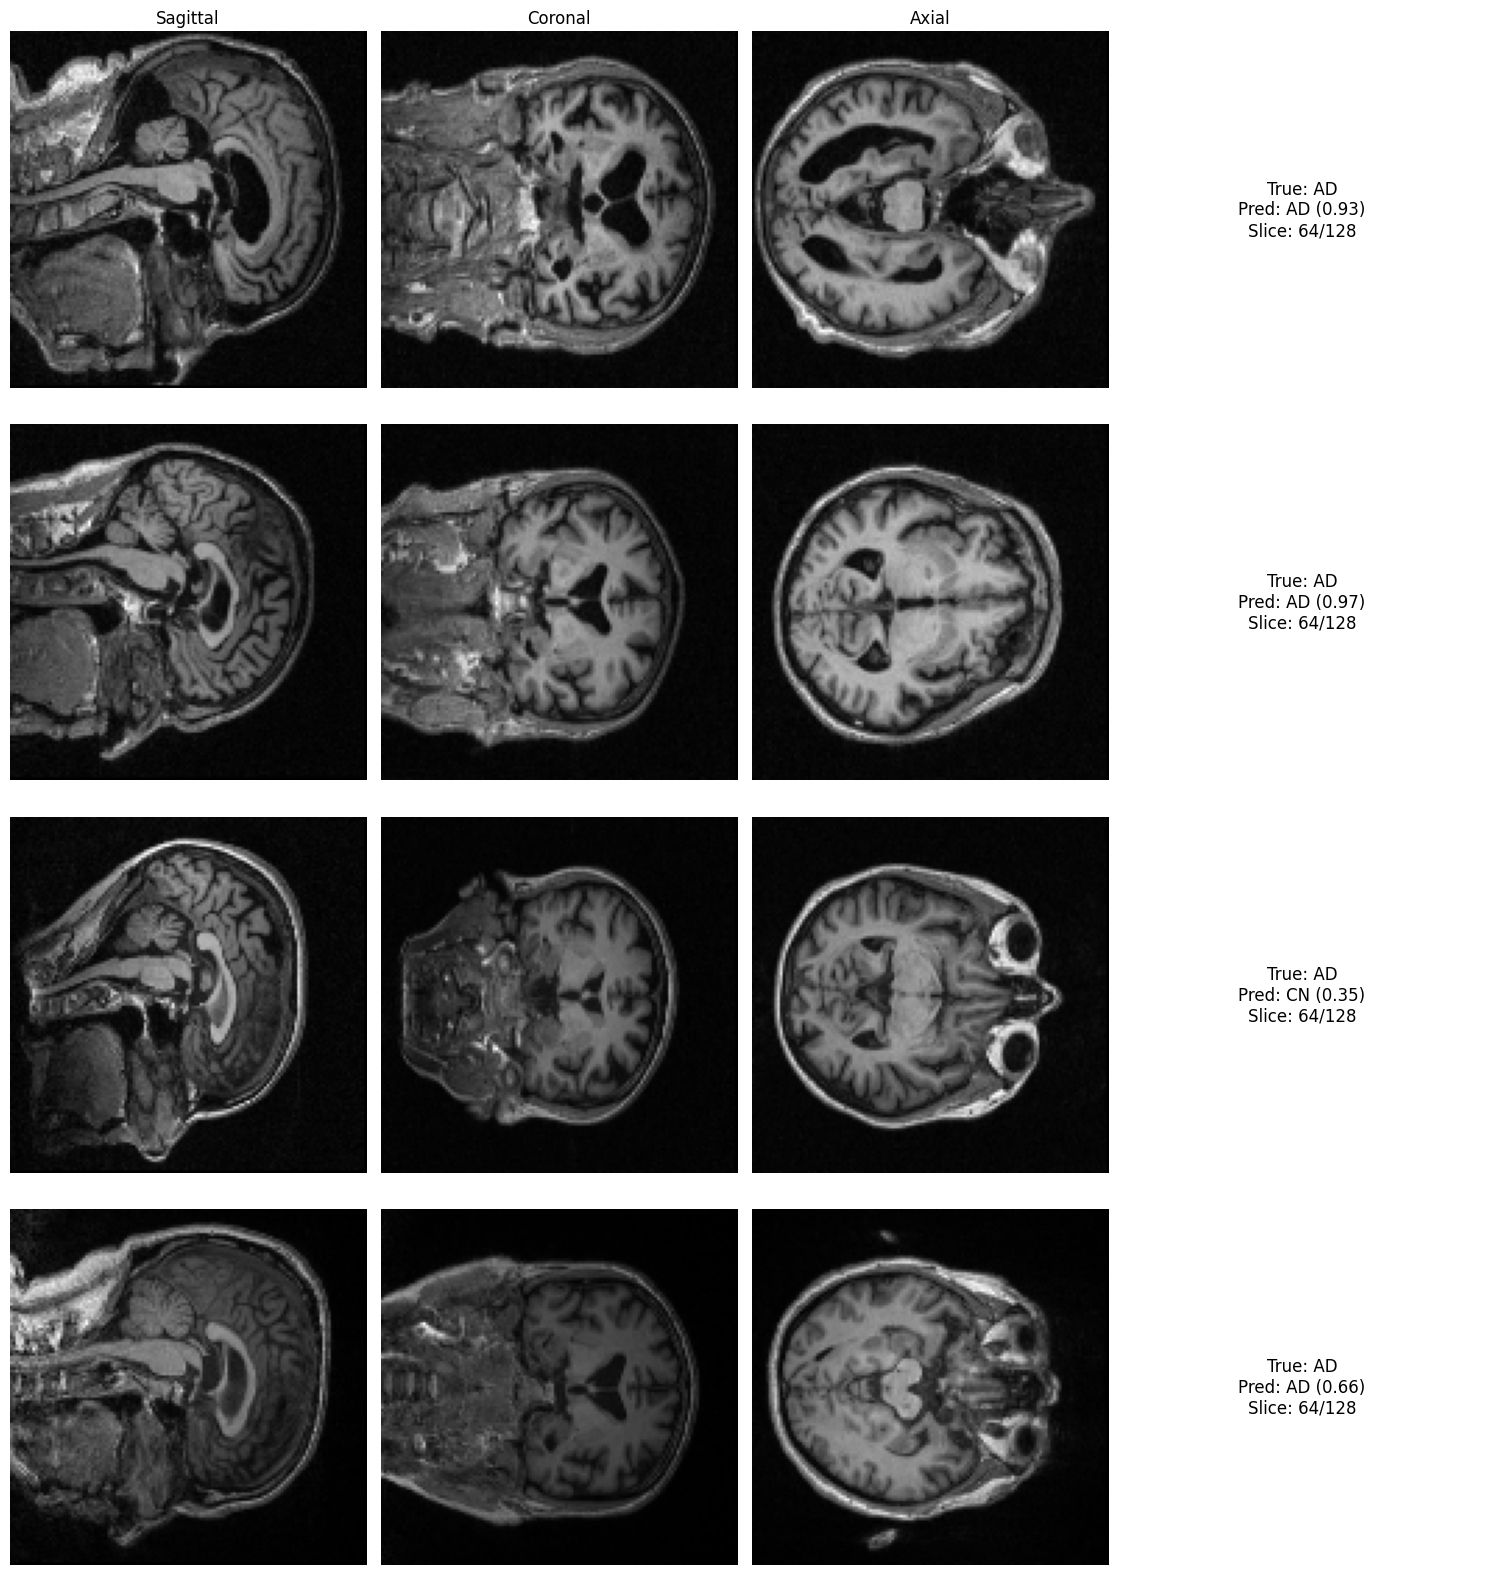

In [ ]:
num_examples = 4
fig, axes = plt.subplots(num_examples, 4, figsize=(15, 4*num_examples))

for idx in range(num_examples):
    volume, label = test_dataset[idx]
    volume = volume.numpy()[0]  # Remove channel dim

    # Show orthogonal slices
    mid_z = volume.shape[0] // 2
    mid_y = volume.shape[1] // 2
    mid_x = volume.shape[2] // 2

    slices = [
        volume[mid_z, :, :],  # Axial
        volume[:, mid_y, :],   # Coronal
        volume[:, :, mid_x]    # Sagittal
    ]

    # Get model prediction
    with torch.no_grad():
        input_tensor = torch.tensor(volume[np.newaxis, np.newaxis, ...]).to(device)
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)[0, 1].item()
        pred = 1 if prob > 0.5 else 0

    # Plot slices
    for j, slice_img in enumerate(slices):
        ax = axes[idx, j]
        ax.imshow(slice_img, cmap='gray')
        ax.axis('off')
        if idx == 0:
            ax.set_title(['Sagittal','Coronal','Axial' ][j])

    # Add prediction info
    ax = axes[idx, 3]
    ax.text(0.5, 0.5,
            f"True: {'AD' if label == 1 else 'CN'}\n"
            f"Pred: {'AD' if pred == 1 else 'CN'} ({prob:.2f})\n"
            f"Slice: {mid_z}/{volume.shape[0]}",
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()
